In [159]:
import os
import networkx as nx
import numpy as np
import heapq
import pandas as pd
import time
import scipy.sparse as sp
import scipy.sparse.linalg as splinalg
import random
import math

def read_txt_network(file_path):
    edges = []
    with open(file_path, 'r') as file:
        for line in file:
            nodes = line.strip().split()
            if len(nodes) == 2:
                edges.append((int(nodes[0]), int(nodes[1])))
    return edges

def Bonacich_centrality_zip(G, pr):
    adj_matrix = nx.adjacency_matrix(G)
    N = G.number_of_nodes()
    
    pre = pr * adj_matrix.toarray()  # Convert sparse matrix to dense array for np.linalg.matrix_power
    pre_Matrix = np.zeros_like(pre)
    
    for i in range(1, 5):  # Accumulate matrix powers from 1 to 4
        pre_Matrix += np.linalg.matrix_power(pre, i)
        
    Bonacich_centrality = pre_Matrix @ np.ones(N)
    Bonacich_centrality = np.round(Bonacich_centrality, 2)
    
    return dict(zip(G.nodes(), Bonacich_centrality))

def ICsim(G, decision_dict , pr, num_iterations):
    results = []  # Store (selected_nodes, decision_combinations, activated_count)
    selected_nodes = list(decision_dict.keys())
    decisions = list(decision_dict.values())
    
    total_activated = 0  # Track the total number of activations across iterations
    for _ in range(num_iterations):
        initial_seeding = [node for node, freq in zip(selected_nodes, decisions) if np.random.rand() < freq]
        
        if not initial_seeding:
            continue

        node_statuses = {node: 1 if node in initial_seeding else 0 for node in G.nodes()}
        next_nodes = list(initial_seeding)  # Stack to store nodes to be processed in next iteration
        activated_count = len(initial_seeding)  # Include initially activated nodes

        # Perform cascade propagation
        while next_nodes:
            current_node = next_nodes.pop()
            for ne in G.successors(current_node):
                # Activate neighbor with probability pr
                if node_statuses[ne] == 0 and np.random.rand() < pr:
                    node_statuses[ne] = 1
                    next_nodes.append(ne)
                    activated_count += 1

        total_activated += activated_count

    expected_activate = total_activated / num_iterations
    
    return expected_activate

def find_activation_plan(G, demands, pr, num_iterations):
    nodes_sorted_by_outdegree = sorted(G.nodes(), key=lambda node: G.out_degree(node), reverse=True)
    
    decision_plan = []
    total_decision_dict = {node: 0 for node in G.nodes()}
    costs = []
    activations = []
    nodes_deg = []

    for demand in demands:
        current_decision_dict = {}
        current_deg_dict = {}
        accumulated_activation = 0
        node_index = 0
        cost = 0
        
        while accumulated_activation < demand and node_index < len(nodes_sorted_by_outdegree):
            current_node = nodes_sorted_by_outdegree[node_index]
            remaining_frequency = 1 - total_decision_dict[current_node]-0.01
            
            if remaining_frequency > 0:
                current_decision_dict[current_node] = remaining_frequency
                current_activation = ICsim(G, current_decision_dict, pr, num_iterations)
                
                if current_activation > demand:
                    needed_frequency = min((demand - accumulated_activation)/(current_activation-accumulated_activation),remaining_frequency)
                    current_decision_dict[current_node] = needed_frequency
                    total_decision_dict[current_node] += needed_frequency
                    accumulated_activation=demand
                else:
                    accumulated_activation = current_activation
                    total_decision_dict[current_node] = 1
                
                cost += G.out_degree(current_node) * round(current_decision_dict[current_node], 2)
            
            node_index += 1
        
        for key, value in current_decision_dict.items():
            current_decision_dict[key] = round(value, 2)
            current_deg_dict[key] = G.out_degree(key)
        current_activation = ICsim(G, current_decision_dict, pr, num_iterations)    
        decision_plan.append(current_decision_dict)
        costs.append(cost)
        activations.append(current_activation)
        nodes_deg.append(current_deg_dict)
    
    return decision_plan, costs, activations, nodes_deg 

def n_Choices(G, k, n, pr, num_iterations):
    results = []  # Store (selected_nodes, decision_combinations, activated_count)
    N = G.number_of_nodes()
    
    # Filter out nodes with centrality <= 10
    filtered_rank_list = [node for node in G.nodes() if G.out_degree(node) > 10]
    
    for _i in range(10):
        Decisions = generate_random_numbers(k, n)
        for choose in range(200):
            selected = random.sample(filtered_rank_list, n)
            for frequency in Decisions:
                expected_activate = 0
                for __ in range(num_iterations):
                    initial_seeding = []
                    for __i in range(n):
                        if np.random.rand() < frequency[__i]:
                            initial_seeding.append(selected[__i])
                            
                    if not initial_seeding:
                        continue
                        
                    node_statuses = {node: 1 if node in initial_seeding else 0 for node in G.nodes()}
                    next_nodes = list(initial_seeding)  # Stack to store nodes to be processed in next iteration
                    activated_count = len(initial_seeding)  # Include initially activated nodes
                        
                    # Perform cascade propagation
                    while next_nodes:
                        current_node = next_nodes.pop()
                        for ne in G.neighbors(current_node):
                            # Activate neighbor with probability a
                            if node_statuses[ne] == 0 and np.random.rand() < pr:
                                node_statuses[ne] = 1
                                next_nodes.append(ne)
                                activated_count += 1
                    expected_activate += activated_count
                                        
                expected_activate /= num_iterations
                result = {
                    "sel": selected,
                    "dec": frequency.tolist(),
                    "act": expected_activate
                }

                results.append(result)
                
    return results

def cost_calcu(G, decision_dict):
    selected_nodes = list(decision_dict.keys())
    print(selected_nodes)
    decisions = list(decision_dict.values())
    print(decisions)
    cost = 0
    ind=0
    for _ in selected_nodes:
        cost += G.out_degree(_)*decisions[ind]
        ind+=1
    print(f"Total cost: {cost}")

# def new_compute_rho(M, tol=1e-2):
#     n = M.shape[0]
#     Ones = np.ones_like(M)
#     ones = np.ones(n)
#     M_t= M.T
    
#     rho_prev = np.zeros_like(M)
#     rho = M.copy()
#     Rho = M.copy() 

#     # 初始化 rho 和 rho_prev
#     rho = M.copy()

#     for k in range(3):
#         # 计算 (1 - rho * M_t) 的乘积
#         prod = np.prod(1 - rho[:, None, :] * M_t[None, :, :], axis=2)
#         # 更新 rho
#         rho = 1 - prod
#         # 对角线元素保持不变
#         np.fill_diagonal(rho, 0)
#         Rho += rho 
 
#     return Rho

def new_compute_rho(M, L=3):
    n = M.shape[0]
    M_t = M.T
    
    rho = M.copy()  # Initialize rho
    Rho = M.copy()  # Initialize Rho with M

    # Pre-allocate arrays for intermediate results
    prod = np.empty((n, n))  # Avoid repeated allocation in the loop

    for k in range(L):
        # Compute element-wise product (1 - rho * M_t) along the third axis
        for i in range(n):
            for j in range(n):
                prod[i, j] = np.prod(1 - rho[i, :] * M_t[j, :])  # Correct the shape alignment

        # Update rho
        rho = 1 - prod
        np.fill_diagonal(rho, 0)  # Keep diagonal elements unchanged
        
        # Increment Rho
        Rho += rho

    return Rho


def compute_rho(M, tol=1e-2):
    n = M.shape[0]
    M_t = M.T  # Transpose of the adjacency matrix
    Rho = M.copy()  # Final influence matrix

    # Initialize rho
    rho = M.copy()

    for k in range(3):  # Iterate over a few steps
        # Create a temporary rho for each iteration
        rho_new = np.ones_like(M)  # Start with a matrix of ones

        # For each pair (i, j), compute the product incrementally
        for i in range(n):
            for j in range(n):
                if i != j:
                    prod = 1.0
                    for l in range(n):
                        if l != i and l != j:
                            prod *= (1 - rho[i, l] * M_t[j, l])
                    rho_new[i, j] = 1 - prod

        # Update rho and accumulate the result in Rho
        rho = rho_new
        np.fill_diagonal(rho, 0)  # Ensure diagonal elements remain zero
        Rho += rho

    return Rho

def Expected_Activated_Matrix(G,decision_dict,Rho):
    Rho = np.copy(Rho)
    nodes_list = list(G.nodes())
    selected_nodes = list(decision_dict.keys())
    decisions = list(decision_dict.values())
    index = [nodes_list.index(node) for node in selected_nodes]
    Exp = sum(decisions)
    
    for i in range(len(index)):
        Rho[index[i]] *= decisions[i]
    
    for o in range(Rho.shape[0]):
        if o not in index:
            _ = 1
            for i in index:
                _ *= 1-Rho[i,o]
            Exp += 1-_
            
    return Exp   

pr = 0.1  # 设定的参数
num_iterations=80

In [2]:
def find_activation_plan(G, demands, pr, num_iterations):
    nodes_sorted_by_outdegree = sorted(G.nodes(), key=lambda node: G.out_degree(node), reverse=True)
    
    decision_plan = []
    total_decision_dict = {node: 0 for node in G.nodes()}
    costs = []
    activations = []

    for demand in demands:
        current_decision_dict = {}
        accumulated_activation = 0
        node_index = 0
        cost = 0
        
        while accumulated_activation < demand and node_index < len(nodes_sorted_by_outdegree):
            current_node = nodes_sorted_by_outdegree[node_index]
            remaining_frequency = 1 - total_decision_dict[current_node]-0.01
            
            if remaining_frequency > 0:
                current_decision_dict[current_node] = remaining_frequency
                current_activation = ICsim(G, current_decision_dict, pr, num_iterations)
                
                if current_activation > demand:
                    needed_frequency = min((demand - accumulated_activation)/(current_activation-accumulated_activation),remaining_frequency)
                    current_decision_dict[current_node] = needed_frequency
                    total_decision_dict[current_node] += needed_frequency
                    accumulated_activation=demand
                else:
                    accumulated_activation = current_activation
                    total_decision_dict[current_node] = 1
                
                cost += G.out_degree(current_node) * round(current_decision_dict[current_node], 2)
            
            node_index += 1
        
        for key, value in current_decision_dict.items():
            current_decision_dict[key] = round(value, 2)
        current_activation = ICsim(G, current_decision_dict, pr, num_iterations)    
        decision_plan.append(current_decision_dict)
        costs.append(cost)
        activations.append(current_activation)
    
    return decision_plan, costs, activations

def cost_calcu(G, decision_dict):
    selected_nodes = list(decision_dict.keys())
    print(selected_nodes)
    decisions = list(decision_dict.values())
    print(decisions)
    cost = 0
    ind=0
    for _ in selected_nodes:
        cost += G.out_degree(_)*decisions[ind]
        ind+=1
    print(f"Total cost: {cost}")

In [4]:
def generate_random_numbers(k, n):
    integers = np.random.randint(1, 11, size=(k, n))  
    decimals = integers / 10.0
    return decimals

def get_top_m_indices_zip(centrality_dict, m):
    # Sort the dictionary by value and get the top m keys (nodes)
    sorted_nodes = sorted(centrality_dict, key=centrality_dict.get, reverse=True)
    return sorted_nodes[:m]

def yunLang_centrality_zip(G, rho):
    N = G.number_of_nodes()
    centrality = rho @ np.ones(N)
    return dict(zip(G.nodes(),centrality))

def Calcul_Residual(G, rho, pr, k, n):
    
    results = []  # Store (exp_act, residual)
    N = G.number_of_nodes()
    centrality = yunLang_centrality_zip(G, rho)
    rank_list = get_top_m_indices_zip(centrality, N)
    
    indices = {value: index for index, value in enumerate(G.nodes())}
    
    for _i in range(10):
        Decisions = generate_random_numbers(k, n)
        for choose in range(100):
            selected = random.sample(rank_list, n)
            for frequency in Decisions:
                decision_dict = dict(zip(selected, frequency))
                exp = Expected_Activated_Matrix(G, decision_dict, rho)
                first = sum(frequency[i] * centrality[selected[i]] for i in range(n))
                selected_rows = rho[[indices[node] for node in selected], :]
                second = 0
                for i in range(len(selected)):
                    for j in range(i, len(selected)):  
                        inner_product =  frequency[i] * frequency[j] * np.dot(selected_rows[i], selected_rows[j])
                        second -= inner_product
            
                act = ICsim(G, decision_dict , pr, 100)
                
                results.append([act, exp, first, second])
    
    return results

import re

def Calcul_EP(G, rho, file_path):
    results = []  # Store (act, exp, first, second)
    pattern = r'sel:\s*\[(.*?)\]\s*dec:\s*\[(.*?)\]\s*act:\s*(\d+\.\d+)'
    N = G.number_of_nodes()
    indices = {value: index for index, value in enumerate(G.nodes())}
    centrality = yunLang_centrality_zip(G, rho)
    
    with open(file_path, 'r') as file:
        for line in file:
            match = re.match(pattern, line)

            if not match:
                raise ValueError(f"Invalid line format: {line}")
                
            sel_part, dec_part, act_part = match.groups()

            selected = [int(node.strip()) for node in sel_part.split(',')]

            frequency = [float(freq.strip()) for freq in dec_part.split(',')]

            act = float(act_part)
            
            decision_dict = dict(zip(selected, frequency))

            exp = Expected_Activated_Matrix(G, decision_dict, rho)
            
            first = sum(frequency[i] * centrality[selected[i]] for i in range(len(selected)))
            
            selected_rows = rho[[indices[node] for node in selected], :]
            
            second = 0
            for i in range(len(selected)):
                for j in range(i, len(selected)):  
                    inner_product = frequency[i] * frequency[j] * np.dot(selected_rows[i], selected_rows[j])
                    second -= inner_product
            
            results.append([act, exp, first, second])
    
    return results

------------------------------------------

In [148]:
import gurobipy as gp
from gurobipy import GRB
# Parameters
num_advertisers = 5  # Number of advertisers
required_activations = [50, 50, 100, 100, 200]  # Activation requirements for each advertiser

# Read network and calculate Bonacich centrality and common neighbors
current_dir = os.getcwd()
folder_name = "Test"
folder_path = os.path.join(current_dir, folder_name)
filename = "socfb-Caltech36.txt"
file_path = os.path.join(folder_path, filename)
edges = read_txt_network(file_path)
G = nx.DiGraph()
G.add_edges_from(edges)

# Get node list and node degrees
nodes_list = list(G.nodes())
influencers = np.array([node for (node, val) in G.out_degree() if val>50])
inf_deg = np.array([val for (node, val) in G.out_degree() if val>50])
index = [nodes_list.index(node) for node in influencers]
num_influencers = len(influencers)
print('There are ',num_influencers,' influcers.')

# 从文件中读取 rho 矩阵
rho_file_path = r'F:\Jupyter\Social network\ForPaper_ending\Data\Caltech36_rho.txt'
rho = np.loadtxt(rho_file_path)

# Calculate centrality
centrality = yunLang_centrality_zip(G, rho)
first_coeffs = np.zeros(num_influencers)
for i, node in enumerate(influencers):
    first_coeffs[i] = centrality.get(node, 0)

# Calculate gamma_coeffs (common neighbors)
second_coeffs_matrix = np.dot(rho,rho.T)
second_coeffs = second_coeffs_matrix[np.ix_(index, index)]

# Create optimization model
model = gp.Model("cost_minimization")

# Create decision variables
x = model.addVars(num_influencers, num_advertisers, lb=0, ub=1, vtype=GRB.CONTINUOUS, name="x")

# Objective function: minimize cost (node degrees * decision variables)
model.setObjective(gp.quicksum(inf_deg[s] * x[s, k] for s in range(num_influencers) for k in range(num_advertisers)), GRB.MINIMIZE)

# Constraints: ensure activation levels are met
activation_constraints = []
for k in range(num_advertisers):
    # Linear part
    linear_part = gp.quicksum(first_coeffs[s] * x[s, k] for s in range(num_influencers))
    # Quadratic part
    quadratic_part = 0.2 *gp.quicksum(second_coeffs[s, t] * x[s, k] * x[t, k] for s in range(num_influencers) for t in range(num_influencers) if s != t)
    # Constraint
    activation_constraints.append(model.addConstr(linear_part - quadratic_part >= required_activations[k], f"ActivationConstraint_{k}"))

# Additional constraint: sum of x_s_k over k should be less than or equal to 1
for s in range(num_influencers):
    model.addConstr(gp.quicksum(x[s, k] for k in range(num_advertisers)) <= 1, f"SumConstraint_{s}")

There are  103  influcers.


In [149]:
# Optimize model
model.Params.MIPGap = 0.01
model.optimize()

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 103 rows, 515 columns and 515 nonzeros
Model fingerprint: 0x09729b92
Model has 5 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [7e-01, 9e+01]
  QLMatrix range   [1e+01, 3e+02]
  Objective range  [5e+01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
  QRHS range       [5e+01, 2e+02]

Continuous model is non-convex -- solving as a MIP

Presolve time: 0.06s
Presolved: 52638 rows, 26780 columns, 132355 nonzeros
Presolved model has 26265 bilinear constraint(s)
Variable types: 26780 continuous, 0 integer (0 binary)
Found heuristic solution: objective 179.2277102

Deterministic concurrent LP optimizer: primal and d

In [150]:
advertiser_costs = np.zeros(num_advertisers)
advertiser_plan = []
advertiser_activations = []
for k in range(num_advertisers):
    choice = {}
    for s in range(num_influencers):
        if x[s, k].x > 0.01:  # Print non-zero decision variables
            print(f'{influencers[s]}'+':'+f'{round(x[s,k].x,2)}'+f'    deg={inf_deg[s]}')
            ind=int(influencers[s])
            advertiser_costs[k] += inf_deg[s] * x[s, k].x
            choice[ind] = x[s, k].x
    advertiser_plan.append(choice)


#         # Calculate the constraint function value for advertiser k
#         linear_part_value = sum(beta_coeffs[s] * x[s, k].x for s in range(num_nodes))
#         quadratic_part_value = sum(gamma_coeffs[s, t] * x[s, k].x * x[t, k].x for s in range(num_nodes) for t in range(num_nodes) if s != t)
#         constraint_value = linear_part_value - quadratic_part_value

    act = ICsim(G, choice, pr, 100)  # Assuming num_iterations is 100 for the simulation
    advertiser_activations.append(act)

    print(f'Actual activation for advertiser {k}: {act}',f'Cost for advertiser {k}:{advertiser_costs[k]}'+'\n')

763:0.07    deg=55
719:0.2    deg=53
736:0.08    deg=54
Actual activation for advertiser 0: 31.52 Cost for advertiser 0:19.07870559173937

736:0.31    deg=54
Actual activation for advertiser 1: 49.24 Cost for advertiser 1:16.52505443240039

719:0.75    deg=53
Actual activation for advertiser 2: 96.49 Cost for advertiser 2:39.98154540786861

736:0.61    deg=54
Actual activation for advertiser 3: 92.7 Cost for advertiser 3:33.05010886480078

750:0.99    deg=69
Actual activation for advertiser 4: 185.43 Cost for advertiser 4:68.53474198790468



In [161]:
# Parameters
num_advertisers = 5  # Number of advertisers
required_activations = [50, 50, 100, 100, 200]  # Activation requirements for each advertiser

# Read network and calculate Bonacich centrality and common neighbors
current_dir = os.getcwd()
folder_name = "Test"
folder_path = os.path.join(current_dir, folder_name)
filename = "socfb-Haverford76.txt"
file_path = os.path.join(folder_path, filename)
edges = read_txt_network(file_path)

G = nx.DiGraph()
G.add_edges_from(edges)

greedy_dec=find_activation_plan(G, required_activations, pr, num_iterations)
print(greedy_dec)

([{860: 0.16}, {860: 0.2}, {860: 0.46}, {860: 0.16, 1445: 0.06}, {1445: 0.31}], [36.0, 45.0, 103.5, 49.44, 69.44], [55.475, 55.2, 132.65, 105.4, 275.925], [{860: 225}, {860: 225}, {860: 225}, {860: 225, 1445: 224}, {1445: 224}])


In [156]:
print(G.out_degree(709))

61


[{860: 0.16}, {860: 0.17}, {860: 0.47}, {860: 0.18, 1445: 0.07}, {1445: 0.3}]


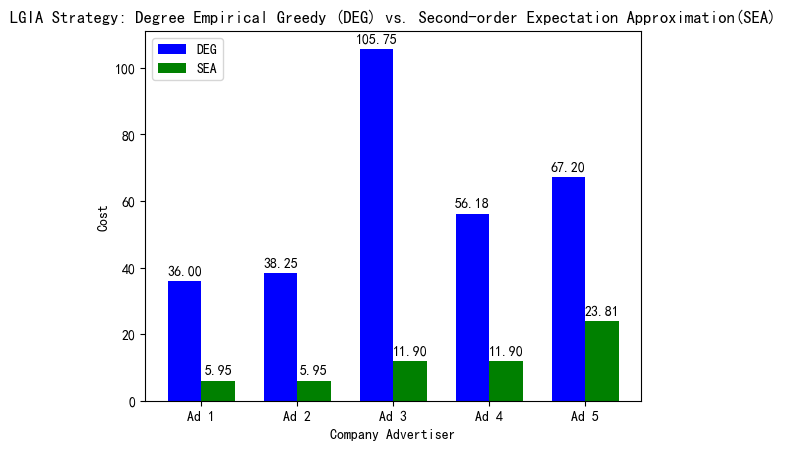

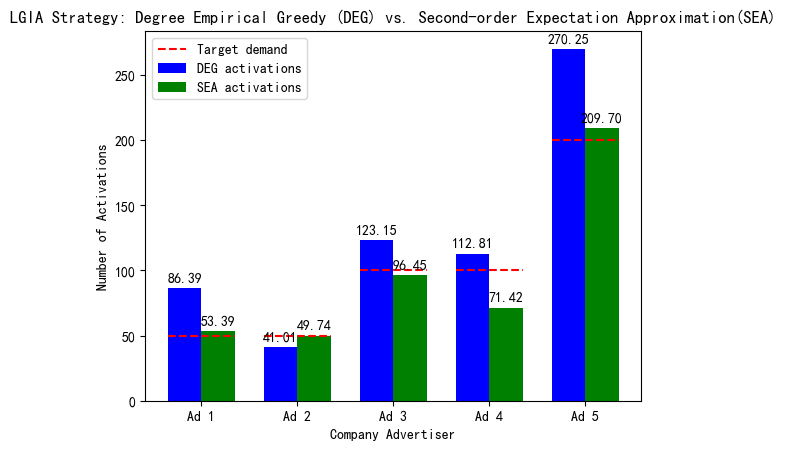

In [145]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 获取贪心算法的成本和激活数目
greedy_decision_plan, greedy_costs, greedy_activations = find_activation_plan(G, required_activations, pr, num_iterations)
print(greedy_decision_plan)
# 绘制对比图
labels = [f'Ad {i+1}' for i in range(num_advertisers)]
x_num = np.arange(len(labels))  # 广告商的数量
width = 0.35  # 柱状图的宽度

fig, ax1 = plt.subplots()

# 成本柱状图
rects1 = ax1.bar(x_num - width/2, greedy_costs, width, label='DEG', color='b')
rects2 = ax1.bar(x_num + width/2, advertiser_costs, width, label='SEA', color='g')

# 在柱状图上添加文本标签
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1, ax1)
autolabel(rects2, ax1)

ax1.set_xlabel('Company Advertiser')
ax1.set_ylabel('Cost')
ax1.set_title('LGIA Strategy: Degree Empirical Greedy (DEG) vs. Second-order Expectation Approximation(SEA)')
ax1.set_xticks(x_num)
ax1.set_xticklabels(labels)
ax1.legend(loc='upper left')

# 激活数目柱状图
advertiser_requirements = [50, 50, 100, 100, 200]

fig, ax2 = plt.subplots()

rects3 = ax2.bar(x_num - width/2, greedy_activations, width, label='DEG activations', color='b')
rects4 = ax2.bar(x_num + width/2, advertiser_activations, width, label='SEA activations', color='g')

autolabel(rects3, ax2)
autolabel(rects4, ax2)

for i, req in enumerate(advertiser_requirements):
    ax2.plot([x_num[i] - width, x_num[i] + width], [req, req], 'r--', label=f'Target demand' if i == 0 else "")

ax2.set_xlabel('Company Advertiser')
ax2.set_ylabel('Number of Activations')
ax2.set_title('LGIA Strategy: Degree Empirical Greedy (DEG) vs. Second-order Expectation Approximation(SEA)')
ax2.set_xticks(x_num)
ax2.set_xticklabels(labels)
ax2.legend(loc='upper left')

plt.show()

In [115]:
if isinstance(greedy_activations, (list, np.ndarray)):
    print("advertiser_activations is valid")
else:
    print("advertiser_activations is invalid")


advertiser_activations is valid


[{860: 0.16}, {860: 0.19}, {860: 0.56}, {860: 0.08, 1445: 0.11}, {1445: 0.3}]


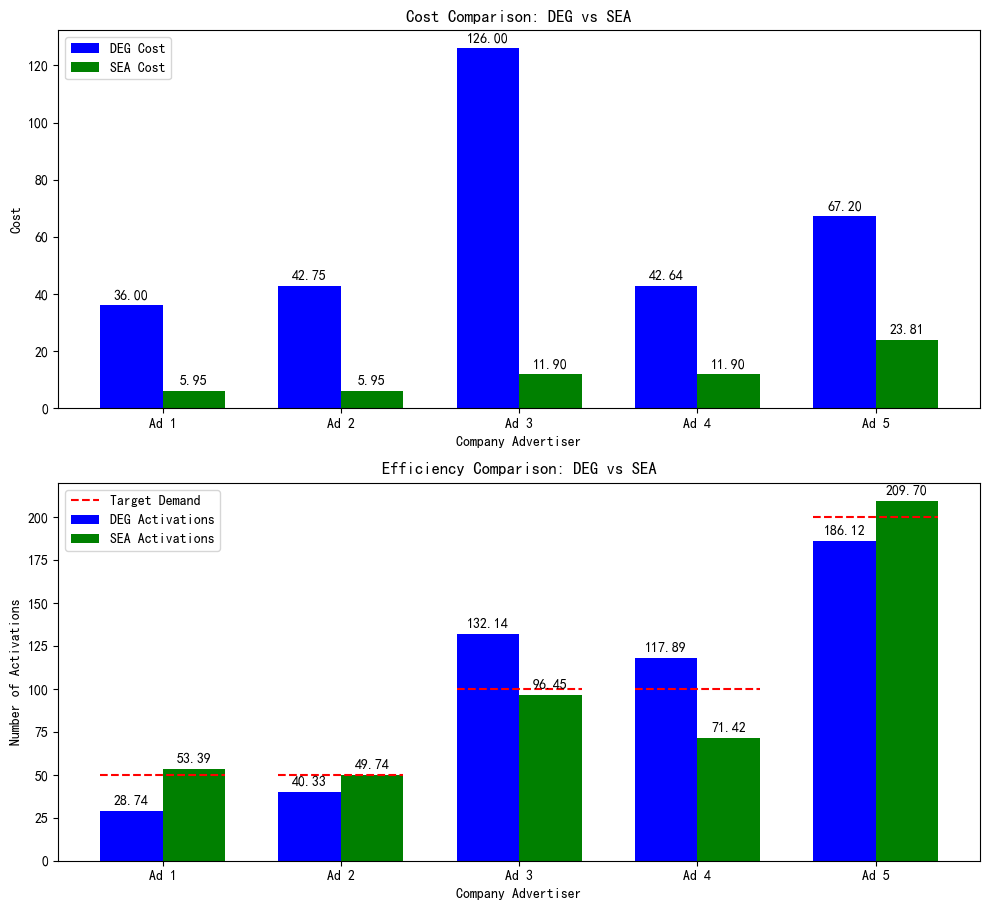

In [147]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
output_folder = "ForPaper_ending"
os.makedirs(output_folder, exist_ok=True)
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 获取贪心算法的成本和激活数目
greedy_decision_plan, greedy_costs, greedy_activations = find_activation_plan(G, required_activations, pr, num_iterations)
print(greedy_decision_plan)

# 绘制对比图
labels = [f'Ad {i+1}' for i in range(num_advertisers)]
x_num = np.arange(len(labels))  # 广告商的数量
width = 0.35  # 柱状图的宽度

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))  # 创建两个子图

# 成本柱状图
rects1 = ax1.bar(x_num - width/2, greedy_costs, width, label='DEG Cost', color='b')
rects2 = ax1.bar(x_num + width/2, advertiser_costs, width, label='SEA Cost', color='g')

# 添加文本标签
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1, ax1)
autolabel(rects2, ax1)

ax1.set_xlabel('Company Advertiser')
ax1.set_ylabel('Cost')
ax1.set_title('Cost Comparison: DEG vs SEA')
ax1.set_xticks(x_num)
ax1.set_xticklabels(labels)
ax1.legend(loc='upper left')

# 激活数目柱状图
advertiser_requirements = [50, 50, 100, 100, 200]
rects3 = ax2.bar(x_num - width/2, greedy_activations, width, label='DEG Activations', color='b')
rects4 = ax2.bar(x_num + width/2, advertiser_activations, width, label='SEA Activations', color='g')

autolabel(rects3, ax2)
autolabel(rects4, ax2)

for i, req in enumerate(advertiser_requirements):
    ax2.plot([x_num[i] - width, x_num[i] + width], [req, req], 'r--', label=f'Target Demand' if i == 0 else "")

ax2.set_xlabel('Company Advertiser')
ax2.set_ylabel('Number of Activations')
ax2.set_title('Efficiency Comparison: DEG vs SEA')
ax2.set_xticks(x_num)
ax2.set_xticklabels(labels)
ax2.legend(loc='upper left')

# 设置整体标题
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 调整子图以适应标题

output_file_path = os.path.join(output_folder, "DEG_vs_SEA_comparison_HarverFord.png")
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')  # 設定 DPI 和邊距
plt.show()


-----------------------------------------------------------------------------------------------------------

In [60]:
current_dir = os.getcwd()
folder_name = "New_test_ending"
output_folder = "ForPaper_ending"
folder_path = os.path.join(current_dir, folder_name)
output_path = os.path.join(current_dir, output_folder)

if not os.path.exists(output_path):
    os.makedirs(output_path)

for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)
    
    if os.path.isdir(subfolder_path):
        socfb_file = None
        other_files = []
        
        for file in os.listdir(subfolder_path):
            if file.startswith("socfb"):
                socfb_file = file
            else:
                other_files.append(file)
        
        if socfb_file is None:
            print(f"Warning: No socfb file found in {subfolder}")
            continue
        
        socfb_file_path = os.path.join(subfolder_path, socfb_file)
        start_time = time.time()
        edges = read_txt_network(socfb_file_path)
        G = nx.DiGraph()
        G.add_edges_from(edges)
        adj_matrix = nx.adjacency_matrix(G)
        pre = pr * adj_matrix.toarray()  # 注意这里假设pr是已定义的变量
        rho = new_compute_rho(pre,3)
        end_time = time.time()
        run_time = end_time - start_time
        run_time_min = run_time / 60
        print(f"Compute Rho for {subfolder}: {run_time_min:.2f} minutes")

        for filename in other_files:
            file_path = os.path.join(subfolder_path, filename)
            start_time = time.time()
            result = Calcul_EP(G, rho, file_path)
            
            new_filename = f"{filename}_L=3_result.txt"
            
            with open(os.path.join(output_path, new_filename), 'w') as file:
                for item in result:
                    line = ' '.join(map(str, item))
                    file.write(line + '\n')
            
            end_time = time.time()
            run_time = end_time - start_time
            run_time_min = run_time / 60
            print(f"{new_filename} Running time: {run_time_min:.2f} minutes")
        
        rho_filename = f"{subfolder}_rho_L=3_.txt"
        np.savetxt(os.path.join(output_path, rho_filename), rho)

Compute Rho for Haverford76: 2.57 minutes
1_socfb-Haverford76.txt_L=3_result.txt Running time: 1.09 minutes
Compute Rho for Reed98: 0.69 minutes
1_socfb-Reed98.txt_L=3_result.txt Running time: 0.57 minutes


In [ ]:
current_dir = os.getcwd()

# 定义路径
folder_name = r"F:\Jupyter\Social network\New_test\Amherst41"
output_folder = "ForPaper_ending"
folder_path = folder_name  # 直接使用绝对路径
output_path = os.path.join(current_dir, output_folder)

# 确保输出目录存在
if not os.path.exists(output_path):
    os.makedirs(output_path)

# 从文件中读取 rho 矩阵
rho_file_path = r'F:\Jupyter\Social network\ForPaper\Amherst41_rho.txt'
rho = np.loadtxt(rho_file_path)

network_name = 'socfb-Amherst41.txt'
network_path = os.path.join(folder_path, network_name)
# 定义要处理的文件名
filename = '20_socfb-Amherst41.txt'
file_path = os.path.join(folder_path, filename)

# 读取网络并创建有向图 G
edges = read_txt_network(network_path)
G = nx.DiGraph()
G.add_edges_from(edges)

# 计算结果
start_time = time.time()
result = Calcul_EP(G, rho, file_path)

# 保存结果到新文件
new_filename = f"{filename}_result.txt"
with open(os.path.join(output_path, new_filename), 'w') as file:
    for item in result:
        line = ' '.join(map(str, item))
        file.write(line + '\n')

end_time = time.time()
run_time = end_time - start_time
run_time_min = run_time / 60
print(f"{new_filename} Running time: {run_time_min:.2f} minutes")

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import math

def remove_outliers_iqr(data, factor=1.5):
    """通过IQR剔除异常值"""
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return (data >= lower_bound) & (data <= upper_bound)

# 输入和输出文件夹路径
input_folders = ["F:/Jupyter/Social network/ForPaper_ending/plot/Caltech36",
                 "F:/Jupyter/Social network/ForPaper_ending/plot/Bowdoin47",
                 "F:/Jupyter/Social network/ForPaper_ending/plot/Amherst41",
                 "F:/Jupyter/Social network/ForPaper_ending/plot/Brandeis99",
                 "F:/Jupyter/Social network/ForPaper_ending/plot/American75"]
                 
                 
output_folder = "F:/Jupyter/Social network/ForPaper_ending"
categories = [ 'Caltech36','Bowdoin47','Amherst41','Brandeis99','American75']
#,'Bowdoin47','Amherst41'] 
#'American75','Amherst41','Bowdoin47',
os.makedirs(output_folder, exist_ok=True)
parameter = [5, 10, 20]
title_font = {
    'size': 40,
    'weight': 'bold',
    'family': 'serif',
    'color': 'blue'
}

for i, folder in enumerate(input_folders):
    files = sorted([f for f in os.listdir(folder) if f.endswith('.txt')], key=lambda x: int(x.split('_')[0]))
    results_ea = {5: [], 10: [], 20: []}
    results_eX = {5: [], 10: [], 20: []}
    coef_ex = {5: [], 10: [], 20: []}
    coef_eX = {5: [], 10: [], 20: []}
    all_re_exp = []
    _ = 0
    
    for filename in files:
        print(filename)
        file_path = os.path.join(folder, filename)
        data = pd.read_csv(file_path, sep=' ', header=None)

        act = data.iloc[:, 0]
        re_exp = data.iloc[:, 1]
        X = data.iloc[:, 2:]

        # 剔除 re_exp 中的异常值
        mask = remove_outliers_iqr(re_exp)  # 通过IQR筛选re_exp的有效范围
        re_exp = re_exp[mask]
        act = act[mask]
        X = X[mask]
        
        #lin_reg_ea = LinearRegression()
        #lin_reg_ea.fit(re_exp.values.reshape(-1, 1), act)
        #re_exp_pred = lin_reg_ea.predict(re_exp.values.reshape(-1, 1))
        #coef_ex[parameter[_]] = lin_reg_ea.coef_
        #intercept = lin_reg_ea.intercept_
        re_exp_pred = re_exp

        residuals_ea = list(zip(re_exp, act - re_exp_pred))
        results_ea[parameter[_]].extend(residuals_ea)

        lin_reg_eX = LinearRegression()
        lin_reg_eX.fit(X, re_exp_pred)
        re_X = lin_reg_eX.predict(X)
        coef_eX[parameter[_]] = lin_reg_eX.coef_
        residuals_eX = list(zip(re_exp, re_X - re_exp_pred))
        results_eX[parameter[_]].extend(residuals_eX)

        all_re_exp.append(re_exp)
        _ += 1

    factor = 3
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    for idx, param in enumerate(parameter):
        x_min = min(all_re_exp[idx]) - 10
        x_max = max(all_re_exp[idx]) + 10
        re_exp = [pair[0] for pair in results_ea[param]]
        residuals_ea = [pair[1] for pair in results_ea[param]]
        residuals_eX = [pair[1] for pair in results_eX[param]]

        relative_residuals_ea = np.array(residuals_ea) / np.array(re_exp)
        relative_residuals_eX = np.array(residuals_eX) / np.array(re_exp)

        mae_ea = np.mean(np.abs(relative_residuals_ea))
        std_dev_ea = np.std(relative_residuals_ea)
        mae_eX = np.mean(np.abs(relative_residuals_eX))
        std_dev_eX = np.std(relative_residuals_eX)

        mask_ea = (relative_residuals_ea >= -factor * std_dev_ea) & (relative_residuals_ea <= factor * std_dev_ea)
        mask_eX = (relative_residuals_eX >= -factor * std_dev_eX) & (relative_residuals_eX <= factor * std_dev_eX)
        mask = mask_ea & mask_eX

        re_exp = np.array(re_exp)[mask]
        relative_residuals_ea = relative_residuals_ea[mask]
        relative_residuals_eX = relative_residuals_eX[mask]
        
        ea_label = f'Expectation vs. Simulation'
        ex_label = f'Expectation vs. SEA Regression'
        axes[idx].scatter(re_exp, relative_residuals_ea, marker='D', s=70, c='red', edgecolor='black', alpha=0.6, label=ea_label)
        axes[idx].scatter(re_exp, relative_residuals_eX, marker='o', s=70, c='blue', edgecolor='black', alpha=0.6, label=ex_label)
        axes[idx].axhline(y=0, color='r', linestyle='--')
        axes[idx].set_xlim(x_min, x_max + 10)
        axes[idx].set_ylim(-1, 1)
        axes[idx].set_xlabel('Expected Value')
        axes[idx].set_ylabel('Relative Residuals')
        axes[idx].set_title(f'n={param},MAE(SE)={mae_ea:.2f}, STD(SE)={std_dev_ea:.2f}\nOLS_SEA: {round(coef_eX[param][0],2),round(coef_eX[param][1],2)},MAE(ER)={mae_eX:.2f}, STD(ER)={std_dev_eX:.2f}')
        axes[idx].legend()

    plt.suptitle(f'Residual Plot for {categories[i]}', fontdict=title_font)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(output_folder, f'network_{i+1}_residual_plot.png'))
    plt.close()

In [8]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import math

# 输入和输出文件夹路径
input_folders = ["F:/Jupyter/Social network/ForPaper_ending/plot/Caltech36",
                 "F:/Jupyter/Social network/ForPaper_ending/plot/Bowdoin47",
                 "F:/Jupyter/Social network/ForPaper_ending/plot/Amherst41",
                 "F:/Jupyter/Social network/ForPaper_ending/plot/Brandeis99",
                 "F:/Jupyter/Social network/ForPaper_ending/plot/American75"]
                 
                 
output_folder = "F:/Jupyter/Social network/ForPaper_ending"
categories = [ 'Caltech36','Bowdoin47','Amherst41','Brandeis99','American75']
#,'Bowdoin47','Amherst41'] 
#'American75','Amherst41','Bowdoin47',
os.makedirs(output_folder, exist_ok=True)
parameter = [5, 10, 20]
title_font = {
    'size': 40,
    'weight': 'bold',
    'family': 'serif',
    'color': 'blue'
}

for i, folder in enumerate(input_folders):
    files = sorted([f for f in os.listdir(folder) if f.endswith('.txt')], key=lambda x: int(x.split('_')[0]))
    results_ea = {5: [], 10: [], 20: []}
    results_eX = {5: [], 10: [], 20: []}
    coef_ex = {5: [], 10: [], 20: []}
    coef_eX = {5: [], 10: [], 20: []}
    all_re_exp = []
    _ = 0
    for filename in files:
        print(filename)
        file_path = os.path.join(folder, filename)
        data = pd.read_csv(file_path, sep=' ', header=None)

        act = data.iloc[:, 0]
        re_exp = data.iloc[:, 1]
        X = data.iloc[:, 2:]
#         print([x for x in re_exp if x<5])
        
        lin_reg_ea = LinearRegression()
        lin_reg_ea.fit(re_exp.values.reshape(-1, 1), act)
        re_exp_pred = lin_reg_ea.predict(re_exp.values.reshape(-1, 1))
        coef_ex[parameter[_]] = lin_reg_ea.coef_
        intercept = lin_reg_ea.intercept_

        residuals_ea = list(zip(re_exp, act - re_exp_pred))
        results_ea[parameter[_]].extend(residuals_ea)

        lin_reg_eX = LinearRegression()
        lin_reg_eX.fit(X, act)
        re_X = lin_reg_eX.predict(X)
        coef_eX[parameter[_]] = lin_reg_eX.coef_
        residuals_eX = list(zip(re_exp, re_X - re_exp_pred))
        results_eX[parameter[_]].extend(residuals_eX)
        intercept_eX = lin_reg_eX.intercept_

        all_re_exp.append(re_exp)
        _ += 1

    factor = 3
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    for idx, param in enumerate(parameter):
        x_min = min(all_re_exp[idx]) - 10
        x_max = max(all_re_exp[idx]) + 10
        re_exp = [pair[0] for pair in results_ea[param]]
        residuals_ea = [pair[1] for pair in results_ea[param]]
        residuals_eX = [pair[1] for pair in results_eX[param]]

        relative_residuals_ea = np.array(residuals_ea) / np.array(re_exp)
        relative_residuals_eX = np.array(residuals_eX) / np.array(re_exp)

        mae_ea = np.mean(np.abs(relative_residuals_ea))
        std_dev_ea = np.std(relative_residuals_ea)
        mae_eX = np.mean(np.abs(relative_residuals_eX))
        std_dev_eX = np.std(relative_residuals_eX)

        mask_ea = (relative_residuals_ea >= -factor * std_dev_ea) & (relative_residuals_ea <= factor * std_dev_ea)
        mask_eX = (relative_residuals_eX >= -factor * std_dev_eX) & (relative_residuals_eX <= factor * std_dev_eX)
        mask = mask_ea & mask_eX

        re_exp = np.array(re_exp)[mask]
        relative_residuals_ea = relative_residuals_ea[mask]
        relative_residuals_eX = relative_residuals_eX[mask]
        
        ea_label = f'Expectation vs. Simulation'
        ex_label = f'Expectation vs. SEA Regression'
        axes[idx].scatter(re_exp, relative_residuals_ea, marker='D', s=70, c='red', edgecolor='black', alpha=0.6, label=ea_label)
        axes[idx].scatter(re_exp, relative_residuals_eX, marker='o', s=70, c='blue', edgecolor='black', alpha=0.6, label=ex_label)
        axes[idx].axhline(y=0, color='r', linestyle='--')
        axes[idx].set_xlim(x_min, x_max + 10)
        axes[idx].set_ylim(-1, 1)
        axes[idx].set_xlabel('Expected Value')
        axes[idx].set_ylabel('Relative Residuals')
        axes[idx].set_title(f'n={param}, OLS_EXP: {round(coef_ex[param][0],2),round(intercept,2)},MAE(SE)={mae_ea:.2f}, STD(SE)={std_dev_ea:.2f}\nOLS_SEA: {round(coef_eX[param][0],2),round(coef_eX[param][1],2),round(intercept_eX,2)},MAE(ER)={mae_eX:.2f}, STD(ER)={std_dev_eX:.2f}')
        axes[idx].legend()

    plt.suptitle(f'Residual Plot for {categories[i]}', fontdict=title_font)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(output_folder, f'network_{i+1}_residual_plot.png'))
    plt.close()

5_socfb-Caltech36.txt_result.txt
10_socfb-Caltech36.txt_result.txt
20_socfb-Caltech36.txt_result.txt
5_socfb-Bowdoin47.txt_result.txt
10_socfb-Bowdoin47.txt_result.txt
20_socfb-Bowdoin47.txt_result.txt
5_socfb-Amherst41.txt_result.txt
10_socfb-Amherst41.txt_result.txt
20_socfb-Amherst41.txt_result.txt
5_socfb-Brandeis99.txt_result.txt
10_socfb-Brandeis99.txt_result.txt
20_socfb-Brandeis99.txt_result.txt
5_socfb-American75.txt_result.txt
10_socfb-American75.txt_result.txt
20_socfb-American75.txt_result.txt


In [12]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import math

def remove_outliers_iqr(data, factor=1.5):
    """通过IQR剔除异常值"""
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return (data >= lower_bound) & (data <= upper_bound)

# 输入和输出文件夹路径
input_folders = ["F:/Jupyter/Social network/ForPaper_ending/plot/Caltech36",
                 "F:/Jupyter/Social network/ForPaper_ending/plot/Bowdoin47",
                 "F:/Jupyter/Social network/ForPaper_ending/plot/Amherst41",
                 "F:/Jupyter/Social network/ForPaper_ending/plot/Brandeis99",
                 "F:/Jupyter/Social network/ForPaper_ending/plot/American75"]
                 
                 
output_folder = "F:/Jupyter/Social network/ForPaper_ending"
categories = [ 'Caltech36','Bowdoin47','Amherst41','Brandeis99','American75']
#,'Bowdoin47','Amherst41'] 
#'American75','Amherst41','Bowdoin47',
os.makedirs(output_folder, exist_ok=True)
parameter = [5, 10, 20]
title_font = {
    'size': 40,
    'weight': 'bold',
    'family': 'serif',
    'color': 'blue'
}

for i, folder in enumerate(input_folders):
    files = sorted([f for f in os.listdir(folder) if f.endswith('.txt')], key=lambda x: int(x.split('_')[0]))
    results_ea = {5: [], 10: [], 20: []}
    results_eX = {5: [], 10: [], 20: []}
    coef_ex = {5: [], 10: [], 20: []}
    coef_eX = {5: [], 10: [], 20: []}
    all_re_exp = []
    _ = 0
    
    for filename in files:
        print(filename)
        file_path = os.path.join(folder, filename)
        data = pd.read_csv(file_path, sep=' ', header=None)

        act = data.iloc[:, 0]
        re_exp = data.iloc[:, 1]
        X = data.iloc[:, 2:]

        # 剔除 re_exp 中的异常值
        mask = remove_outliers_iqr(re_exp)  # 通过IQR筛选re_exp的有效范围
        re_exp = re_exp[mask]
        act = act[mask]
        X = X[mask]
        
        #lin_reg_ea = LinearRegression()
        #lin_reg_ea.fit(re_exp.values.reshape(-1, 1), act)
        #re_exp_pred = lin_reg_ea.predict(re_exp.values.reshape(-1, 1))
        #coef_ex[parameter[_]] = lin_reg_ea.coef_
        #intercept = lin_reg_ea.intercept_
        re_exp_pred = re_exp

        residuals_ea = list(zip(re_exp, act - re_exp_pred))
        results_ea[parameter[_]].extend(residuals_ea)

        lin_reg_eX = LinearRegression()
        lin_reg_eX.fit(X, re_exp_pred)
        re_X = lin_reg_eX.predict(X)
        coef_eX[parameter[_]] = lin_reg_eX.coef_
        residuals_eX = list(zip(re_exp, re_X - re_exp_pred))
        results_eX[parameter[_]].extend(residuals_eX)

        all_re_exp.append(re_exp)
        _ += 1

    factor = 3
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    for idx, param in enumerate(parameter):
        x_min = min(all_re_exp[idx]) - 10
        x_max = max(all_re_exp[idx]) + 10
        re_exp = [pair[0] for pair in results_ea[param]]
        residuals_ea = [pair[1] for pair in results_ea[param]]
        residuals_eX = [pair[1] for pair in results_eX[param]]

        relative_residuals_ea = np.array(residuals_ea) / np.array(re_exp)
        relative_residuals_eX = np.array(residuals_eX) / np.array(re_exp)

        mae_ea = np.mean(np.abs(relative_residuals_ea))
        std_dev_ea = np.std(relative_residuals_ea)
        mae_eX = np.mean(np.abs(relative_residuals_eX))
        std_dev_eX = np.std(relative_residuals_eX)

        mask_ea = (relative_residuals_ea >= -factor * std_dev_ea) & (relative_residuals_ea <= factor * std_dev_ea)
        mask_eX = (relative_residuals_eX >= -factor * std_dev_eX) & (relative_residuals_eX <= factor * std_dev_eX)
        mask = mask_ea & mask_eX

        re_exp = np.array(re_exp)[mask]
        relative_residuals_ea = relative_residuals_ea[mask]
        relative_residuals_eX = relative_residuals_eX[mask]
        
        ea_label = f'Expectation vs. Simulation'
        ex_label = f'Expectation vs. SEA Regression'
        axes[idx].scatter(re_exp, relative_residuals_ea, marker='D', s=70, c='red', edgecolor='black', alpha=0.6, label=ea_label)
        axes[idx].scatter(re_exp, relative_residuals_eX, marker='o', s=70, c='blue', edgecolor='black', alpha=0.6, label=ex_label)
        axes[idx].axhline(y=0, color='r', linestyle='--')
        axes[idx].set_xlim(x_min, x_max + 10)
        axes[idx].set_ylim(-1, 1)
        axes[idx].set_xlabel('Expected Value')
        axes[idx].set_ylabel('Relative Residuals')
        axes[idx].set_title(f'n={param},MAE(SE)={mae_ea:.2f}, STD(SE)={std_dev_ea:.2f}\nOLS_SEA: {round(coef_eX[param][0],2),round(coef_eX[param][1],2)},MAE(ER)={mae_eX:.2f}, STD(ER)={std_dev_eX:.2f}')
        axes[idx].legend()

    plt.suptitle(f'Residual Plot for {categories[i]}', fontdict=title_font)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(output_folder, f'network_{i+1}_residual_plot.png'))
    plt.close()

5_socfb-Caltech36.txt_result.txt
10_socfb-Caltech36.txt_result.txt
20_socfb-Caltech36.txt_result.txt
5_socfb-Bowdoin47.txt_result.txt
10_socfb-Bowdoin47.txt_result.txt
20_socfb-Bowdoin47.txt_result.txt
5_socfb-Amherst41.txt_result.txt
10_socfb-Amherst41.txt_result.txt
20_socfb-Amherst41.txt_result.txt
5_socfb-Brandeis99.txt_result.txt
10_socfb-Brandeis99.txt_result.txt
20_socfb-Brandeis99.txt_result.txt
5_socfb-American75.txt_result.txt
10_socfb-American75.txt_result.txt
20_socfb-American75.txt_result.txt


IndexError: list index out of range

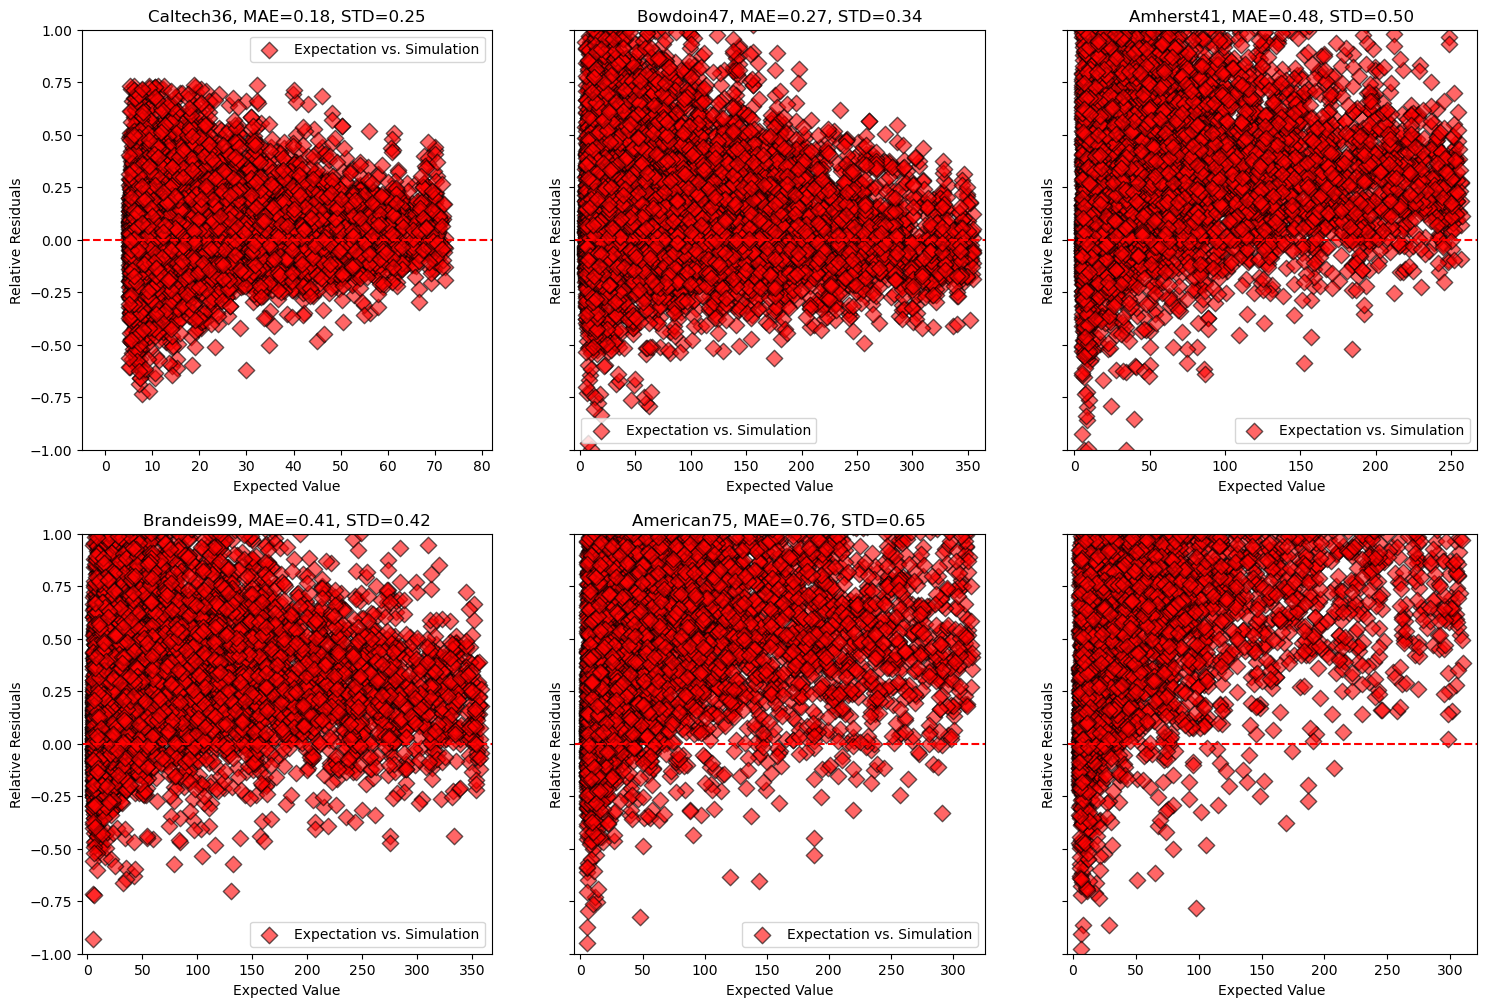

In [61]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 文件路徑列表
file_paths = [
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Caltech36.txt_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Haverford76.txt_L=3_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Bowdoin47.txt_L=6_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Amherst41.txt_L=6_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Brandeis99.txt_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-American75.txt_result.txt'
]

# 對應類別名稱
categories = ['Caltech36', 'Bowdoin47', 'Amherst41', 'Brandeis99', 'American75']

# 輸出文件夾
output_folder = "F:/Jupyter/Social network/ForPaper_ending"
os.makedirs(output_folder, exist_ok=True)

# 標題字體設置
title_font = {
    'size': 40,
    'weight': 'bold',
    'family': 'serif',
    'color': 'blue'
}

# 函數: 移除 IQR 範圍外的異常值 (假設此函數已有實現)
def remove_outliers_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (data >= lower_bound) & (data <= upper_bound) & (data>5)

# 結果數據存儲
results_ea = []
all_re_exp = []

# 讀取數據並計算殘差
for i, file in enumerate(file_paths):
    data = pd.read_csv(file, sep=' ', header=None)

    act = data.iloc[:, 0]  # 真實值
    re_exp = data.iloc[:, 1]  # 預期值

    # 剔除 re_exp 中的異常值
    mask = remove_outliers_iqr(re_exp)
    re_exp = re_exp[mask]
    act = act[mask]

    # 計算相對殘差
    residuals_ea = list(zip(re_exp, act - re_exp))
    results_ea.append(residuals_ea)

    # 存儲 re_exp 用於後續繪圖
    all_re_exp.append(re_exp)

# 繪製殘差圖
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
axes = axes.flatten()

for idx, residual_data in enumerate(results_ea):
    if idx >= 6:  # 只處理5個文件
        break

    re_exp = [pair[0] for pair in residual_data]
    residuals_ea = [pair[1] for pair in residual_data]
    relative_residuals_ea = np.array(residuals_ea) / np.array(re_exp)
    mae_ea = np.mean(np.abs(relative_residuals_ea))
    std_dev_ea = np.std(relative_residuals_ea)

    # 移除極端值 (3個標準差範圍內)
    mask_ea = (relative_residuals_ea >= -3 * std_dev_ea) & (relative_residuals_ea <= 3 * std_dev_ea)
    relative_residuals_ea = relative_residuals_ea[mask_ea]
    re_exp = np.array(re_exp)[mask_ea]

    # 繪製散點圖
    ea_label = f'Expectation vs. Simulation'
    axes[idx].scatter(re_exp, relative_residuals_ea, marker='D', s=70, c='red', edgecolor='black', alpha=0.6, label=ea_label)
    axes[idx].axhline(y=0, color='r', linestyle='--')
    axes[idx].set_xlim(min(re_exp) - 10, max(re_exp) + 10)
    axes[idx].set_ylim(-1, 1)
    axes[idx].set_xlabel('Expected Value')
    axes[idx].set_ylabel('Relative Residuals')
    axes[idx].set_title(f'{categories[idx]}, MAE={mae_ea:.2f}, STD={std_dev_ea:.2f}')
    axes[idx].legend()

# 移除未用的第6個子圖

# 添加總標題
plt.suptitle('Residual Plot for 6 Networks', fontdict=title_font)

# 調整佈局
plt.tight_layout(rect=[0, 0, 1, 0.95])

# 保存並關閉 (只保存一次)
plt.savefig(os.path.join(output_folder, 'combined_network_residual_plot.png'))

plt.close()

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 文件路徑列表
file_paths = [
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Caltech36.txt_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Bowdoin47.txt_L=6_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Amherst41.txt_L=6_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Brandeis99.txt_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-American75.txt_result.txt'
]

# 對應類別名稱
categories = ['Caltech36', 'Bowdoin47', 'Amherst41', 'Brandeis99', 'American75']

# 輸出文件夾
output_folder = "F:/Jupyter/Social network/ForPaper_ending"
os.makedirs(output_folder, exist_ok=True)

# 標題字體設置
title_font = {
    'size': 40,
    'weight': 'bold',
    'family': 'serif',
    'color': 'blue'
}

# 函數: 移除 IQR 範圍外的異常值
def remove_outliers_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (data >= lower_bound) & (data <= upper_bound) & (data > 5)

# 結果數據存儲
results_ea = []
all_re_exp = []

# 讀取數據並計算殘差
for i, file in enumerate(file_paths):
    data = pd.read_csv(file, sep=' ', header=None)

    act = data.iloc[:, 0]  # 真實值
    re_exp = data.iloc[:, 1]  # 預期值

    # 剔除 re_exp 中的異常值
    mask = remove_outliers_iqr(re_exp)
    re_exp = re_exp[mask]
    act = act[mask]

    # 計算相對殘差
    residuals_ea = list(zip(re_exp, act - re_exp))
    results_ea.append(residuals_ea)

    # 存儲 re_exp 用於後續繪圖
    all_re_exp.append(re_exp)

# 繪製雲圖
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
axes = axes.flatten()

for idx, residual_data in enumerate(results_ea):
    if idx >= 5:  # 只處理5個文件
        break

    re_exp = [pair[0] for pair in residual_data]
    residuals_ea = [pair[1] for pair in residual_data]
    relative_residuals_ea = np.array(residuals_ea) / np.array(re_exp)
    mae_ea = np.mean(np.abs(relative_residuals_ea))
    std_dev_ea = np.std(relative_residuals_ea)

    # 移除極端值 (3個標準差範圍內)
    mask_ea = (relative_residuals_ea >= -3 * std_dev_ea) & (relative_residuals_ea <= 3 * std_dev_ea)
    relative_residuals_ea = relative_residuals_ea[mask_ea]
    re_exp = np.array(re_exp)[mask_ea]

    # 繪製雲圖
    axes[idx].hexbin(re_exp, relative_residuals_ea, gridsize=50, cmap='Blues', mincnt=1)
    axes[idx].axhline(y=0, color='r', linestyle='--')
    axes[idx].set_xlim(min(re_exp) - 10, max(re_exp) + 10)
    axes[idx].set_ylim(-1, 1)
    axes[idx].set_xlabel('Expected Value')
    axes[idx].set_ylabel('Relative Residuals')
    axes[idx].set_title(f'{categories[idx]}, MAE={mae_ea:.2f}, STD={std_dev_ea:.2f}')

# 移除未用的第6個子圖
fig.delaxes(axes[5])

# 添加總標題
plt.suptitle('Residual Cloud Plot for 5 Networks', fontdict=title_font)

# 調整佈局
plt.tight_layout(rect=[0, 0, 1, 0.95])

# 保存並關閉 (只保存一次)
plt.savefig(os.path.join(output_folder, 'combined_network_residual_cloud_plot.png'))

plt.close()


In [63]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 文件路徑列表
file_paths = [
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Caltech36.txt_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Haverford76.txt_L=3_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Bowdoin47.txt_L=6_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Amherst41.txt_L=6_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Brandeis99.txt_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-American75.txt_result.txt'
]

# 對應類別名稱
categories = ['Caltech36','Haverford76', 'Bowdoin47', 'Amherst41', 'Brandeis99', 'American75']

# 輸出文件夾
output_folder = "F:/Jupyter/Social network/ForPaper_ending"
os.makedirs(output_folder, exist_ok=True)

# 標題字體設置
title_font = {
    'size': 40,
    'weight': 'bold',
    'family': 'serif',
    'color': 'blue'
}

# 函數: 移除 IQR 範圍外的異常值
def remove_outliers_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (data >= lower_bound) & (data <= upper_bound) & (data > 5)

# 結果數據存儲
results_ea = []

# 讀取數據並計算殘差
for i, file in enumerate(file_paths):
    data = pd.read_csv(file, sep=' ', header=None)

    act = data.iloc[:, 0]  # 真實值
    re_exp = data.iloc[:, 1]  # 預期值

    # 剔除 re_exp 中的異常值
    mask = remove_outliers_iqr(re_exp)
    re_exp = re_exp[mask]
    act = act[mask]

    # 存儲結果
    results_ea.append((re_exp, act))

# 繪製雲圖
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (re_exp, act) in enumerate(results_ea):
    if idx >= 6:  # 只處理5個文件
        break

    # 繪製雲圖，縱坐標為實際值
    axes[idx].hexbin(re_exp, act, gridsize=50, cmap='flag', mincnt=1)
    axes[idx].set_xlabel('Expected Value')
    axes[idx].set_ylabel('Actual Value')
    axes[idx].set_title(f'{categories[idx]}')

    # 添加 y=x 的示例線
    max_value = max(max(re_exp), max(act))
    axes[idx].plot([0, max_value], [0, max_value], 'r--', label='y = x')
    axes[idx].legend()

# 添加總標題
plt.suptitle('Actual Value Cloud Plot for 5 Networks', fontdict=title_font)

# 調整佈局
plt.tight_layout(rect=[0, 0, 1, 0.95])

# 保存並關閉 (只保存一次)
plt.savefig(os.path.join(output_folder, 'combined_network_actual_value_cloud_plot.png'))

plt.close()

In [68]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 文件路徑列表
file_paths = [
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Caltech36.txt_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Haverford76.txt_L=3_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Bowdoin47.txt_L=6_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Amherst41.txt_L=6_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Brandeis99.txt_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-American75.txt_result.txt'
]

# 對應類別名稱
categories = ['Caltech36','Haverford76', 'Bowdoin47', 'Amherst41', 'Brandeis99', 'American75']

# 輸出文件夾
output_folder = "F:/Jupyter/Social network/ForPaper_ending"
os.makedirs(output_folder, exist_ok=True)

# 標題字體設置
title_font = {
    'size': 40,
    'weight': 'bold',
    'family': 'serif',
    'color': 'blue'
}

# 函數: 移除 IQR 範圍外的異常值
def remove_outliers_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (data >= lower_bound) & (data <= upper_bound) & (data > 5)

# 結果數據存儲
results_ea = []

# 讀取數據並計算殘差
for i, file in enumerate(file_paths):
    data = pd.read_csv(file, sep=' ', header=None)

    act = data.iloc[:, 0]  # 真實值
    re_exp = data.iloc[:, 1]  # 預期值

    # 剔除 re_exp 中的異常值
    mask = remove_outliers_iqr(re_exp)
    re_exp = re_exp[mask]
    act = act[mask]

    # 存儲結果
    results_ea.append((re_exp, act))

# 繪製雲圖
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (re_exp, act) in enumerate(results_ea):
    if idx >= 6:  # 只處理6個文件
        break
# 計算標準差
    sigma = np.std(re_exp)

    # 繪製雲圖
    axes[idx].hexbin(re_exp, act, gridsize=50, cmap='flag', mincnt=1, alpha=0.7)
    axes[idx].set_xlabel('Expected Value')
    axes[idx].set_ylabel('Actual Value')
    axes[idx].set_title(f'{categories[idx]}')

    # 添加 y=x 的示例線
    max_value = max(max(re_exp), max(act))
    axes[idx].plot([0, max_value], [0, max_value], 'g--', label='y = x')

    # 添加透明色帶
    axes[idx].fill_between(
        re_exp,
        re_exp - sigma,
        re_exp + sigma,
        color='gray',
        alpha=0.3,
        label='±1 Sigma'
    )

    axes[idx].legend()

    # 自適應坐標軸範圍
    axes[idx].set_xlim(min(re_exp), max(re_exp))
    axes[idx].set_ylim(min(act), max(act))

# 添加總標題
plt.suptitle('Actual Value Cloud Plot for Facebook Networks', fontdict=title_font)

# 調整佈局
plt.tight_layout(rect=[0, 0, 1, 0.95])

# 保存並關閉 (只保存一次)
plt.savefig(os.path.join(output_folder, 'combined_network_actual_value_cloud_plot.png'))

plt.close()


In [76]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 文件路徑列表
file_paths = [
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Caltech36.txt_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Haverford76.txt_L=3_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Bowdoin47.txt_L=6_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Amherst41.txt_L=6_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Brandeis99.txt_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-American75.txt_result.txt'
]

# 對應類別名稱
categories = ['Caltech36', 'Haverford76', 'Bowdoin47', 'Amherst41', 'Brandeis99', 'American75']

# 輸出文件夾
output_folder = "F:/Jupyter/Social network/ForPaper_ending"
os.makedirs(output_folder, exist_ok=True)

# 標題字體設置
title_font = {
    'size': 40,
    'weight': 'bold',
    'family': 'serif',
    'color': 'blue'
}

# 函數: 移除 IQR 範圍外的異常值
def remove_outliers_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (data >= lower_bound) & (data <= upper_bound) & (data > 5)

# 結果數據存儲
results_ea = []

# 讀取數據並計算殘差
for i, file in enumerate(file_paths):
    data = pd.read_csv(file, sep=' ', header=None)

    act = data.iloc[:, 0]  # 真實值
    re_exp = data.iloc[:, 1]  # 預期值

    # 剔除 re_exp 中的異常值
    mask = remove_outliers_iqr(re_exp)
    re_exp = re_exp[mask]
    act = act[mask]

    # 存儲結果
    results_ea.append((re_exp, act))

# 繪製雲圖
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (re_exp, act) in enumerate(results_ea):
    if idx >= 6:  # 只處理6個文件
        break
    
    # 計算標準差
    sigma = np.std(re_exp)

    # 繪製雲圖
    axes[idx].hexbin(re_exp, act, gridsize=50, cmap='flag', mincnt=1, alpha=0.7)
    axes[idx].set_xlabel('Expected Value')
    axes[idx].set_ylabel('Actual Value')
    axes[idx].set_title(f'{categories[idx]}')

    # 添加 y=x 的示例線
    max_value = max(max(re_exp), max(act))
    axes[idx].plot([0, max_value], [0, max_value], 'g--', label='y = x')
    lower_bound = np.array([0, 0])  # 从原点开始
    upper_bound = np.array([max_value, max_value])  # 到 y=x 的最大值
    axes[idx].fill_between(
    [lower_bound[0], upper_bound[0]],  # X 轴范围
    [lower_bound[1] - sigma, upper_bound[1] - sigma],  # 下界
    [lower_bound[1] + sigma, upper_bound[1] + sigma],  # 上界
    color='gray',
    alpha=0.3,
    label='±1 Sigma'
    )

    axes[idx].legend()

    # 自適應坐標軸範圍
    axes[idx].set_xlim(min(re_exp), max(re_exp))
    axes[idx].set_ylim(min(act), max(act))

# 添加總標題
plt.suptitle('Actual Value Cloud Plot for Facebook Networks', fontdict=title_font)

# 調整佈局
plt.tight_layout(rect=[0, 0, 1, 0.95])

# 保存並關閉 (只保存一次)
plt.savefig(os.path.join(output_folder, 'combined_network_actual_value_cloud_plot.png'))

plt.close()


In [20]:
current_dir = os.getcwd()
folder_name = "New_test_ending"
output_folder = "ForPaper_ending"
folder_path = os.path.join(current_dir, folder_name)
output_path = os.path.join(current_dir, output_folder)

if not os.path.exists(output_path):
    os.makedirs(output_path)

for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)
    
    if os.path.isdir(subfolder_path):
        socfb_file = None
        other_files = []
        
        for file in os.listdir(subfolder_path):
            if file.startswith("socfb"):
                socfb_file = file
            else:
                other_files.append(file)
        
        if socfb_file is None:
            print(f"Warning: No socfb file found in {subfolder}")
            continue
        
        socfb_file_path = os.path.join(subfolder_path, socfb_file)
        start_time = time.time()
        edges = read_txt_network(socfb_file_path)
        G = nx.DiGraph()
        G.add_edges_from(edges)
        adj_matrix = nx.adjacency_matrix(G)
        pre = pr * adj_matrix.toarray()  # 注意这里假设pr是已定义的变量
        rho = new_compute_rho(pre,3)
        end_time = time.time()
        run_time = end_time - start_time
        run_time_min = run_time / 60
        print(f"Compute Rho for {subfolder}: {run_time_min:.2f} minutes")

        for filename in other_files:
            file_path = os.path.join(subfolder_path, filename)
            start_time = time.time()
            result = Calcul_EP(G, rho, file_path)
            
            new_filename = f"{filename}_result.txt"
            
            with open(os.path.join(output_path, new_filename), 'w') as file:
                for item in result:
                    line = ' '.join(map(str, item))
                    file.write(line + '\n')
            
            end_time = time.time()
            run_time = end_time - start_time
            run_time_min = run_time / 60
            print(f"{new_filename} Running time: {run_time_min:.2f} minutes")
        
        rho_filename = f"{subfolder}_rho.txt"
        np.savetxt(os.path.join(output_path, rho_filename), rho)

Compute Rho for American75: 187.88 minutes
10_socfb-American75.txt_result.txt Running time: 25.01 minutes
1_socfb-American75.txt_result.txt Running time: 20.67 minutes
20_socfb-American75.txt_result.txt Running time: 29.61 minutes
5_socfb-American75.txt_result.txt Running time: 22.56 minutes
Compute Rho for Amherst41: 8.48 minutes
10_socfb-Amherst41.txt_result.txt Running time: 3.17 minutes
1_socfb-Amherst41.txt_result.txt Running time: 2.24 minutes
20_socfb-Amherst41.txt_result.txt Running time: 4.36 minutes
5_socfb-Amherst41.txt_result.txt Running time: 2.68 minutes
Compute Rho for Bowdoin47: 8.46 minutes
10_socfb-Bowdoin47.txt_result.txt Running time: 3.20 minutes
1_socfb-Bowdoin47.txt_result.txt Running time: 2.23 minutes
20_socfb-Bowdoin47.txt_result.txt Running time: 4.41 minutes
5_socfb-Bowdoin47.txt_result.txt Running time: 2.66 minutes
Compute Rho for Brandeis99: 40.33 minutes
10_socfb-Brandeis99.txt_result.txt Running time: 7.99 minutes
1_socfb-Brandeis99.txt_result.txt Runni

In [ ]:
file_paths = [
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Caltech36.txt_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Bowdoin47.txt_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Amherst41.txt_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-Brandeis99.txt_result.txt',
    r'F:\Jupyter\Social network\ForPaper_ending\1v1\1_socfb-American75.txt_result.txt'
]

output_folder = "F:/Jupyter/Social network/ForPaper_ending"
categories = [ 'Caltech36','Bowdoin47','Amherst41','Brandeis99','American75']

os.makedirs(output_folder, exist_ok=True)
title_font = {
    'size': 40,
    'weight': 'bold',
    'family': 'serif',
    'color': 'blue'
}
results_ea = []
all_re_exp = []

for i, file in file_paths:
    
    data = pd.read_csv(file, sep=' ', header=None)

    act = data.iloc[:, 0]
    re_exp = data.iloc[:, 1]

    # 剔除 re_exp 中的异常值
    mask = remove_outliers_iqr(re_exp)  # 通过IQR筛选re_exp的有效范围
    re_exp = re_exp[mask]

    residuals_ea = list(re_exp, act - re_exp)
    results_ea.extend(residuals_ea)

    all_re_exp.append(re_exp)
    _ += 1

fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
for idx, param in enumerate(parameter):
    x_min = min(all_re_exp[idx]) - 10
    x_max = max(all_re_exp[idx]) + 10
    re_exp = [pair[0] for pair in results_ea[param]]
    residuals_ea = [pair[1] for pair in results_ea[param]]
    relative_residuals_ea = np.array(residuals_ea) / np.array(re_exp)
    mae_ea = np.mean(np.abs(relative_residuals_ea))
    std_dev_ea = np.std(relative_residuals_ea)

    mask_ea = (relative_residuals_ea >= -factor * std_dev_ea) & (relative_residuals_ea <= factor * std_dev_ea)

    relative_residuals_ea = relative_residuals_ea[mask]

    ea_label = f'Expectation vs. Simulation'
    axes[idx].scatter(re_exp, relative_residuals_ea, marker='D', s=70, c='red', edgecolor='black', alpha=0.6, label=ea_label)
    axes[idx].axhline(y=0, color='r', linestyle='--')
    axes[idx].set_xlim(x_min, x_max + 10)
    axes[idx].set_ylim(-1, 1)
    axes[idx].set_xlabel('Expected Value')
    axes[idx].set_ylabel('Relative Residuals')
    axes[idx].set_title(f'n={param},MAE(SE)={mae_ea:.2f}, STD(SE)={std_dev_ea:.2f}\nOLS_SEA: {round(coef_eX[param][0],2),round(coef_eX[param][1],2)},MAE(ER)={mae_eX:.2f}, STD(ER)={std_dev_eX:.2f}')
    axes[idx].legend()

plt.suptitle(f'Residual Plot for {categories[i]}', fontdict=title_font)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(output_folder, f'network_{i+1}_residual_plot.png'))
plt.close()

In [155]:
current_dir = os.getcwd()
folder_name = "Test"
folder_path = os.path.join(current_dir, folder_name)
filename = "socfb-Haverford76.txt"
file_path = os.path.join(folder_path, filename)
edges = read_txt_network(file_path)

G = nx.DiGraph()
G.add_edges_from(edges)
print(G.number_of_edges())
print(G.number_of_nodes())

59589
1446
